CT volume stitching

Prepration: first need to find out roughly which slice coressponding to which slice before image registration

In [1]:
import numpy as np
import cv2
import os
import scipy.io as sio

import matplotlib.pyplot as plt

import seaborn as sns
from skimage.feature import ORB, match_descriptors
from skimage.feature import plot_matches
from skimage.transform import ProjectiveTransform
from skimage.measure import ransac
from skimage.feature import plot_matches
from skimage.filters import median
from skimage.morphology import disk

from skimage.transform import SimilarityTransform, EuclideanTransform
from skimage.color import gray2rgb
from skimage.exposure import rescale_intensity
from skimage.transform import warp
from skimage.transform import match_histograms
import math

In [2]:
path1 = 'Data\Left' # folder of the frist CT volumn
path2 = 'Data\Mid'# folder of the second CT volumn

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        f = os.path.join(folder,filename)
        img =cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        if img is not None:
            images.append(img)
    return images



### Load data

In [4]:
data_left = load_images_from_folder(path1)
data_right = load_images_from_folder(path2)

data_left = np.swapaxes(data_left,1, 2)
data_right = np.swapaxes(data_right,1, 2)

print ('left image has size:', np.shape(data_left))
print ('right image has size:', np.shape(data_right))

left image has size: (995, 737, 76)
right image has size: (996, 977, 76)


### Pre alignment to find the approximate image plane

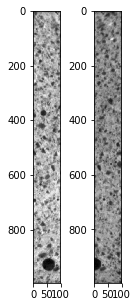

In [63]:
left_index = 33
right_index = 40

image0 = data_left[:,-100:,left_index]
image1 = data_right[:,1:100,right_index] # remove the first pixel


fig, axs = plt.subplots(1,2, figsize = (2,5))
axs[0].imshow(image0, cmap = 'gray')
axs[1].imshow(image1, cmap = 'gray')

### Histogram matching

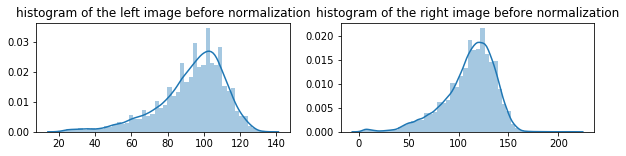

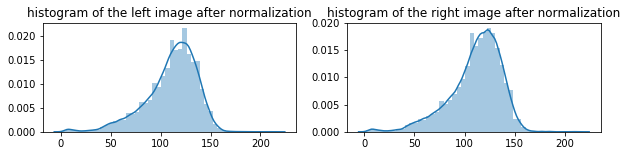

In [64]:
plt.figure(figsize = (10,2))
ax1 = plt.subplot(121)
sns.distplot(image0.ravel(),ax=ax1)
plt.title('histogram of the left image before normalization')
ax2 = plt.subplot(122)
sns.distplot(image1.ravel(),ax=ax2)
plt.title('histogram of the right image before normalization')

image = image0
reference = image1
matched = match_histograms(image, reference, multichannel=False)

plt.figure(figsize = (10,2))
ax1 = plt.subplot(121)
sns.distplot(reference.ravel(),ax=ax1)
plt.title('histogram of the left image after normalization')
ax2 = plt.subplot(122)
sns.distplot(matched.ravel(),ax=ax2)
plt.title('histogram of the right image after normalization')

image0 = matched.astype(np.uint8)
image0 = np.divide(image0,2)
image1 = reference.astype(np.uint8)
image1 = np.divide(image1,2)

### Image registration

In [6]:
orb = ORB(n_keypoints=1000)

orb.detect_and_extract(image0)
keypoints1 = orb.keypoints
descriptors1 = orb.descriptors

orb.detect_and_extract(image1)
keypoints2 = orb.keypoints
descriptors2 = orb.descriptors

matches12 = match_descriptors(descriptors1, descriptors2, cross_check=True)

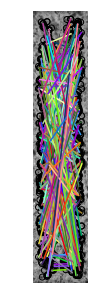

In [68]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12)
ax.axis('off');

In [66]:
# Select keypoints from the source (image to be registered)
# and target (reference image)
src = keypoints2[matches12[:, 1]][:, ::-1]
dst = keypoints1[matches12[:, 0]][:, ::-1]

model_robust, inliers = ransac((src, dst), EuclideanTransform,
                               min_samples=2, max_trials = 10000, residual_threshold=5, random_state = 20)


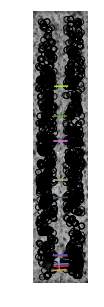

In [67]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plot_matches(ax, image0, image1, keypoints1, keypoints2, matches12[inliers])
ax.axis('off');

### Merge image

In [9]:
#from skimage.transform import SimilarityTransform

r, c = image1.shape[:2]

# Note that transformations take coordinates in (x, y) format,
# not (row, column), in order to be consistent with most literature
corners = np.array([[0, 0],
                    [0, r],
                    [c, 0],
                    [c, r]])

# Warp the image corners to their new positions
warped_corners = model_robust(corners)

# Find the extents of both the reference image and the warped
# target image
all_corners = np.vstack((warped_corners, corners))

corner_min = np.min(all_corners, axis=0)
corner_max = np.max(all_corners, axis=0)

output_shape = (corner_max - corner_min)
output_shape = np.ceil(output_shape[::-1])

offset = EuclideanTransform(translation=-corner_min)
image0_ = warp(image0, offset.inverse,
               output_shape=output_shape, cval=-1)
image1_ = warp(image1, (model_robust + offset).inverse,
               output_shape=output_shape, cval=-1)

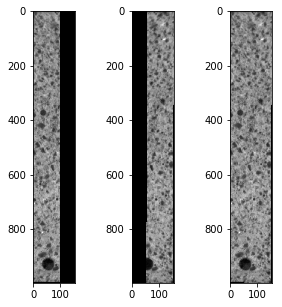

In [58]:
plt.figure(figsize = (5,5))
ax1 = plt.subplot(131)
plt.imshow(image0_,cmap = 'gray')
ax2 = plt.subplot(132)
plt.imshow(image1_,cmap = 'gray')

image_merge = np.where(image0_ == -1, image1_,image0_)
plt.subplot(133)
plt.imshow(image_merge, cmap = 'gray')

### Merge the full image

In [13]:
image_left = data_left[:,:-100,left_index] # get the remaining part
image_right= data_right[:,100:,right_index]

In [14]:
np.shape(data_right)

(996, 977, 76)

In [20]:
image_merge = match_histograms(image_merge, image_left, multichannel=False)
image_right = match_histograms(image_right, image_left, multichannel=False)


In [21]:
np.shape(image_right)

(996, 877)

In [17]:
np.shape(image_merge[:-2,:])

(995, 154)

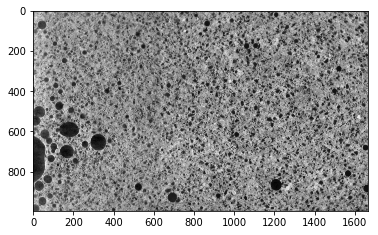

In [54]:
image_merge_full = np.hstack((image_left,image_merge[:-2,:-3],image_right[1:,:]))
plt.imshow(image_merge_full, cmap = 'gray')